In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from editdistance import eval as edit_distance

from simplipy import SimpliPyEngine

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.metrics import bootstrapped_metric_ci, zss_tree_edit_distance
from flash_ansr.eval.metrics.token_prediction import f1_score, precision, recall

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation', 'noise_sweep')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
engine = SimpliPyEngine.load('dev_7-3', install=True)

In [4]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'pysr': {'scaling_parameter': 'noise'},
    'nesymres': {'scaling_parameter': 'noise'},
    'e2e': {'scaling_parameter': 'noise'},
    'v23.0-3M': {'scaling_parameter': 'noise'},
    'v23.0-20M': {'scaling_parameter': 'noise'},
    'v23.0-120M': {'scaling_parameter': 'noise'},
    # 'skeleton_pool': {'scaling_parameter': 'noise'},
    # 'brute_force': {'scaling_parameter': 'noise'},
}

In [5]:
TEST_SETS = ['v23_val', 'fastsrb'][1:]

In [6]:
def parse_p_notation(value):
    """Convert strings like '0p001' to floats (e.g., 0.001)."""
    if value is None:
        return np.nan
    if isinstance(value, (int, float, np.floating)):
        return float(value)

    if not isinstance(value, str):
        raise TypeError(f"Unsupported type for parse_p_notation: {type(value)}")

    cleaned = value.strip().replace('p', '.')
    try:
        return float(cleaned)
    except ValueError:
        return np.nan

In [7]:
models_not_found = []
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    results[model]['evaluations_list'] = {}
    found_dataset = False
    for dataset in TEST_SETS:
        try:
            evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, model, dataset))
            found_dataset = True
        except FileNotFoundError:
            print(f"{os.path.join(PATH_TO_EVALUATION_DATA, model, dataset)} not found, skipping.")
            continue

        evaluations_list = [d for d in evaluations_list if d.startswith(f'{scaling_parameter}_')]

        parsed_scaling_values, valid_evaluations_list = [], []
        for d in evaluations_list:
            parsed_value = parse_p_notation(d.split('_')[-1].split('.')[0])
            if np.isnan(parsed_value):
                print(f"Could not parse scaling value from {d}, skipping.")
                continue
            parsed_scaling_values.append(parsed_value)
            valid_evaluations_list.append(d)

        scaling_values_argsort = np.argsort(parsed_scaling_values)
        scaling_values = [parsed_scaling_values[i] for i in scaling_values_argsort]
        evaluations_list = [valid_evaluations_list[i] for i in scaling_values_argsort]

        results[model]['scaling_values'] = scaling_values
        results[model]['evaluations_list'][dataset] = evaluations_list
        results[model]['results'] = {}

        print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
        for d in evaluations_list:
            print(f" - {d}")

    if not found_dataset:
        print(f"No datasets found for model {model}, removing from results.")
        models_not_found.append(model)

for model_not_found in models_not_found:
    del results[model_not_found]

Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl
Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl
Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl
Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl
Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl
Found 4 evaluations with scaling values: [0.0, 0.001, 0.01, 0.1]
 - noise_0p000.pkl
 - noise_0p001.pkl
 - noise_0p010.pkl
 - noise_0p100.pkl


In [8]:
results

{'pysr': {'scaling_parameter': 'noise',
  'evaluations_list': {'fastsrb': ['noise_0p000.pkl',
    'noise_0p001.pkl',
    'noise_0p010.pkl',
    'noise_0p100.pkl']},
  'scaling_values': [0.0, 0.001, 0.01, 0.1],
  'results': {}},
 'nesymres': {'scaling_parameter': 'noise',
  'evaluations_list': {'fastsrb': ['noise_0p000.pkl',
    'noise_0p001.pkl',
    'noise_0p010.pkl',
    'noise_0p100.pkl']},
  'scaling_values': [0.0, 0.001, 0.01, 0.1],
  'results': {}},
 'e2e': {'scaling_parameter': 'noise',
  'evaluations_list': {'fastsrb': ['noise_0p000.pkl',
    'noise_0p001.pkl',
    'noise_0p010.pkl',
    'noise_0p100.pkl']},
  'scaling_values': [0.0, 0.001, 0.01, 0.1],
  'results': {}},
 'v23.0-3M': {'scaling_parameter': 'noise',
  'evaluations_list': {'fastsrb': ['noise_0p000.pkl',
    'noise_0p001.pkl',
    'noise_0p010.pkl',
    'noise_0p100.pkl']},
  'scaling_values': [0.0, 0.001, 0.01, 0.1],
  'results': {}},
 'v23.0-20M': {'scaling_parameter': 'noise',
  'evaluations_list': {'fastsrb': ['

In [9]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for dataset in TEST_SETS:
        if dataset not in results[model]['evaluations_list']:
            continue
        for d in tqdm(results[model]['evaluations_list'][dataset], desc="Loading evaluation results"):
            for test_set in TEST_SETS:
                path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, model, test_set, d)
                if not os.path.exists(path_to_pickle):
                    print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                    continue
                with open(path_to_pickle, 'rb') as f:
                    print(f"Loading {path_to_pickle}...")
                    try:
                        result = pickle.load(f)
                    except Exception as e:
                        print(f"Error loading {path_to_pickle}: {e}")
                        continue
                scaling_parameter_value = parse_p_notation(d.split('_')[-1].split('.')[0])
                if np.isnan(scaling_parameter_value):
                    print(f"Could not parse scaling value from {d}, skipping.")
                    continue
                if test_set not in results[model]['results']:
                    results[model]['results'][test_set] = {}
                results[model]['results'][test_set][scaling_parameter_value] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 29.05it/s]


Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/pysr/fastsrb/noise_0p000.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/pysr/fastsrb/noise_0p001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/pysr/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/pysr/fastsrb/noise_0p100.pkl...
dict_keys(['fastsrb'])


Loading evaluation results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/nesymres/fastsrb/noise_0p000.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/nesymres/fastsrb/noise_0p001.pkl...


Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 10.26it/s]


Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/nesymres/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/nesymres/fastsrb/noise_0p100.pkl...
dict_keys(['fastsrb'])


Loading evaluation results:  75%|███████▌  | 3/4 [00:00<00:00, 26.06it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/e2e/fastsrb/noise_0p000.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/e2e/fastsrb/noise_0p001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/e2e/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/e2e/fastsrb/noise_0p100.pkl...


Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 25.67it/s]


dict_keys(['fastsrb'])


Loading evaluation results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-3M/fastsrb/noise_0p000.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-3M/fastsrb/noise_0p001.pkl...


Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 27.21it/s]


Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-3M/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-3M/fastsrb/noise_0p100.pkl...
dict_keys(['fastsrb'])


Loading evaluation results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-20M/fastsrb/noise_0p000.pkl...


Loading evaluation results:  50%|█████     | 2/4 [00:00<00:00, 17.54it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-20M/fastsrb/noise_0p001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-20M/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-20M/fastsrb/noise_0p100.pkl...


Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 18.72it/s]


dict_keys(['fastsrb'])


Loading evaluation results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-120M/fastsrb/noise_0p000.pkl...


Loading evaluation results:  50%|█████     | 2/4 [00:00<00:00, 18.54it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-120M/fastsrb/noise_0p001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-120M/fastsrb/noise_0p010.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/noise_sweep/v23.0-120M/fastsrb/noise_0p100.pkl...


Loading evaluation results: 100%|██████████| 4/4 [00:00<00:00, 18.25it/s]

dict_keys(['fastsrb'])


In [10]:
# Sort the results[model]['results']['fastsrb'].keys() and similar ones
for model in results.keys():
    for test_set in TEST_SETS:
        if test_set in results[model]['results']:
            sorted_keys = sorted(results[model]['results'][test_set].keys())
            results[model]['results'][test_set] = {k: results[model]['results'][test_set][k] for k in sorted_keys}

In [11]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'skeleton': [],
    'skeleton_simplified': [],
    'expression': [],
    'variables': [],
    'variable_names': [],
    'complexity': np.nan,
    'placeholder_reason': None,
    'benchmark_metadata': {},
    'ground_truth_infix': [],
    'ground_truth_prefix': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_expression': [],
    'predicted_expression_prefix': [],
    'predicted_skeleton_prefix': [],
    'predicted_skeleton_prefix_raw': [],
    'predicted_constants': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,

    'f1_score': 0.0,
    'skeleton_length': np.inf,
    'expression_length': np.inf,
    'predicted_skeleton_prefix_length': np.inf,
    'fvu_fit': np.inf,
    'fvu_val': np.inf,
    'log10_fvu_fit': np.inf,
    'log10_fvu_val': np.inf,
    'only_approx_fvu_fit': np.inf,
    'only_approx_fvu_val': np.inf,
    'only_approx_log10_fvu_fit': np.inf,
    'only_approx_log10_fvu_val': np.inf,
    'numeric_recovery_fit': 0.0,
    'numeric_recovery_val': 0.0,
    'n_variables': np.nan,
    'n_constants': np.inf,
    'predicted_n_constants': np.inf,
    'n_constants_delta': np.inf,
    'symbolic_recovery': 0.0,
    'skeleton_length_ratio': np.inf,
    'edit_distance': np.inf,
    'zss_edit_distance': np.inf,
    'unique_variables': np.nan,
    'predicted_unique_variables': 0,
    'f1_score_unique_variables': 0.0,
    'precision_unique_variables': 0.0,
    'recall_unique_variables': 0.0,
    'total_nestedness': np.nan,
    'predicted_total_nestedness': np.inf,
}

In [12]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [13]:
results.keys()

dict_keys(['pysr', 'nesymres', 'e2e', 'v23.0-3M', 'v23.0-20M', 'v23.0-120M'])

In [14]:
# For PySR and NeSymReS, the padding has been removed from the input data for the evaluation.
# PySR supports "variable renaming" during evaluation, but NeSymReS does not.
# For NeSymReS, this has transformed the variables from, e.g. ['x3', 'x11', 'x12'] to ['x_1', 'x_2', 'x_3']
# To compute symbolic metrics, we need to transform them back to the original variable names.

def rename_variables_nesymres(skeleton, original_variable_names, *args, **kwargs):
    if skeleton is None or original_variable_names is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) - 1  # 'x_1' -> 0
            if index < len(original_variable_names):
                renamed_skeleton.append(original_variable_names[index])
            else:
                renamed_skeleton.append(token)  # fallback to original token if index out of range
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

def rename_variables_pysr(skeleton, *args, **kwargs):
    # PySR's variables start at x0, x1, while the ground truth starts at x1, x2, ...
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x'):
            index = int(token[1:]) + 1  # 'x0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

# For E2E, the variables are named as x_0, x_1, etc. We need to rename them back to x1, x2, ...
def rename_variables_e2e(skeleton, *args, **kwargs):
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) + 1  # 'x_0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

for model_rename, rename_method in [('nesymres', rename_variables_nesymres), ('pysr', rename_variables_pysr), ('e2e', rename_variables_e2e)]:
    if not model_rename in results:
        continue
    for test_set in results[model_rename]['results'].keys():
        for niterations in results[model_rename]['results'][test_set].keys():
            r = results[model_rename]['results'][test_set][niterations]

            unique_variables_in_ground_truth = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton']]
            
            # The raw predicted skeleton will be stored in 'predicted_skeleton_prefix_raw'
            r['predicted_skeleton_prefix_raw'] = r['predicted_skeleton_prefix'].copy()
            r['predicted_skeleton_prefix'] = [
                rename_method(predicted_skeleton_prefix, variable_names)
                for predicted_skeleton_prefix, variable_names in zip(r['predicted_skeleton_prefix_raw'], unique_variables_in_ground_truth)
            ]

In [15]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return np.inf
        return 0
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
        
    if not isinstance(y_pred, np.ndarray) and np.isnan(y_pred):
        return np.inf

    y_pred = y_pred.astype(np.float64).ravel()
    y_true = y_true.astype(np.float64).ravel()

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    return safe_divide(ss_res, ss_tot)

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps

def total_nestedness(prefix_skeleton: list[str]) -> int:
    nestedness = 0
    current_depth = 0
    for i, token in enumerate(prefix_skeleton):
        if engine.operator_arity.get(token, 0) == 1:
            current_depth += 1
        else:
            nestedness += max(0, current_depth - 1)
            current_depth = 0

    return nestedness

for model in tqdm(results.keys()):
    for test_set in results[model]['results'].keys():
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                r = results[model]['results'][test_set][scaling_value]
                r[f'fvu_{split}'] = np.array([fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'log10_fvu_{split}'] = np.array([log10_fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'numeric_recovery_{split}'] = np.array([is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])

                r[f'only_approx_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'fvu_{split}'])
                r[f'only_approx_log10_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'log10_fvu_{split}'])

            r[f'skeleton_simplified'] = [
                engine.simplify(skeleton, max_pattern_length=4) if skeleton is not None else None
                for skeleton in r['skeleton']]

            r['f1_score'] = np.array([
                f1_score(np.array([predicted_skeleton_prefix]), np.array([skeleton])) if predicted_skeleton_prefix is not None else None  # Will be filled with default negatives in the cell below
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r['skeleton_length'] = np.array([
                len(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_skeleton_prefix_length'] = np.array([
                len(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['n_constants'] = np.array([
                skeleton.count('<constant>') if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_n_constants'] = np.array([
                predicted_skeleton_prefix.count('<constant>') if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_constants_delta'] = np.array([
                predicted_n_constants - true_n_constants if predicted_n_constants is not None and true_n_constants is not None else None
                for predicted_n_constants, true_n_constants in zip(r['predicted_n_constants'], r['n_constants'])])

            r[f'symbolic_recovery'] = np.array([
                predicted_skeleton_prefix == skeleton if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r[f'skeleton_length_ratio'] = np.array([
                safe_divide(predicted_length, true_length) if predicted_length is not None and true_length is not None else None
                for predicted_length, true_length in zip(r['predicted_skeleton_prefix_length'], r['skeleton_length'])])

            r['edit_distance'] = np.array([
                edit_distance(predicted_skeleton_prefix, skeleton) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['zss_edit_distance'] = np.array([
                zss_tree_edit_distance(predicted_skeleton_prefix, skeleton, engine.operator_arity) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['unique_variables'] = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']]

            r['predicted_unique_variables'] = [
                sorted(list(set(token for token in predicted_skeleton_prefix if token.startswith('x'))), key=lambda x: int(x[1:])) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']]
            
            r['f1_score_unique_variables'] = np.array([
                f1_score([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['precision_unique_variables'] = np.array([
                precision([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['recall_unique_variables'] = np.array([
                recall([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['total_nestedness'] = np.array([
                total_nestedness(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])

            r['predicted_total_nestedness'] = np.array([
                total_nestedness(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            

# print(results[list(results.keys())[0]]['results']['feynman'][1]['edit_distance'][:4])

 67%|██████▋   | 4/6 [00:48<00:26, 13.22s/it]/tmp/ipykernel_29743/712976652.py:27: RuntimeWarning: overflow encountered in square
  ss_res = np.mean((y_true - y_pred) ** 2)
100%|██████████| 6/6 [01:18<00:00, 13.08s/it]


In [16]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [17]:
# results[list(results.keys())[0]]['results']['feynman'][1]['fvu_val'].shape, results[list(results.keys())[0]]['results']['feynman'][1]['fit_time'].shape

In [18]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}" if int(float(lower)) != float(lower) else f"{int(float(lower))}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}" if int(float(upper)) != float(upper) else f"{int(float(upper))}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

In [19]:
def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

In [20]:
# FIXME: vNRR at 1 point?

/tmp/ipykernel_29743/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/metrics/bootstrap.py:27: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1395: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


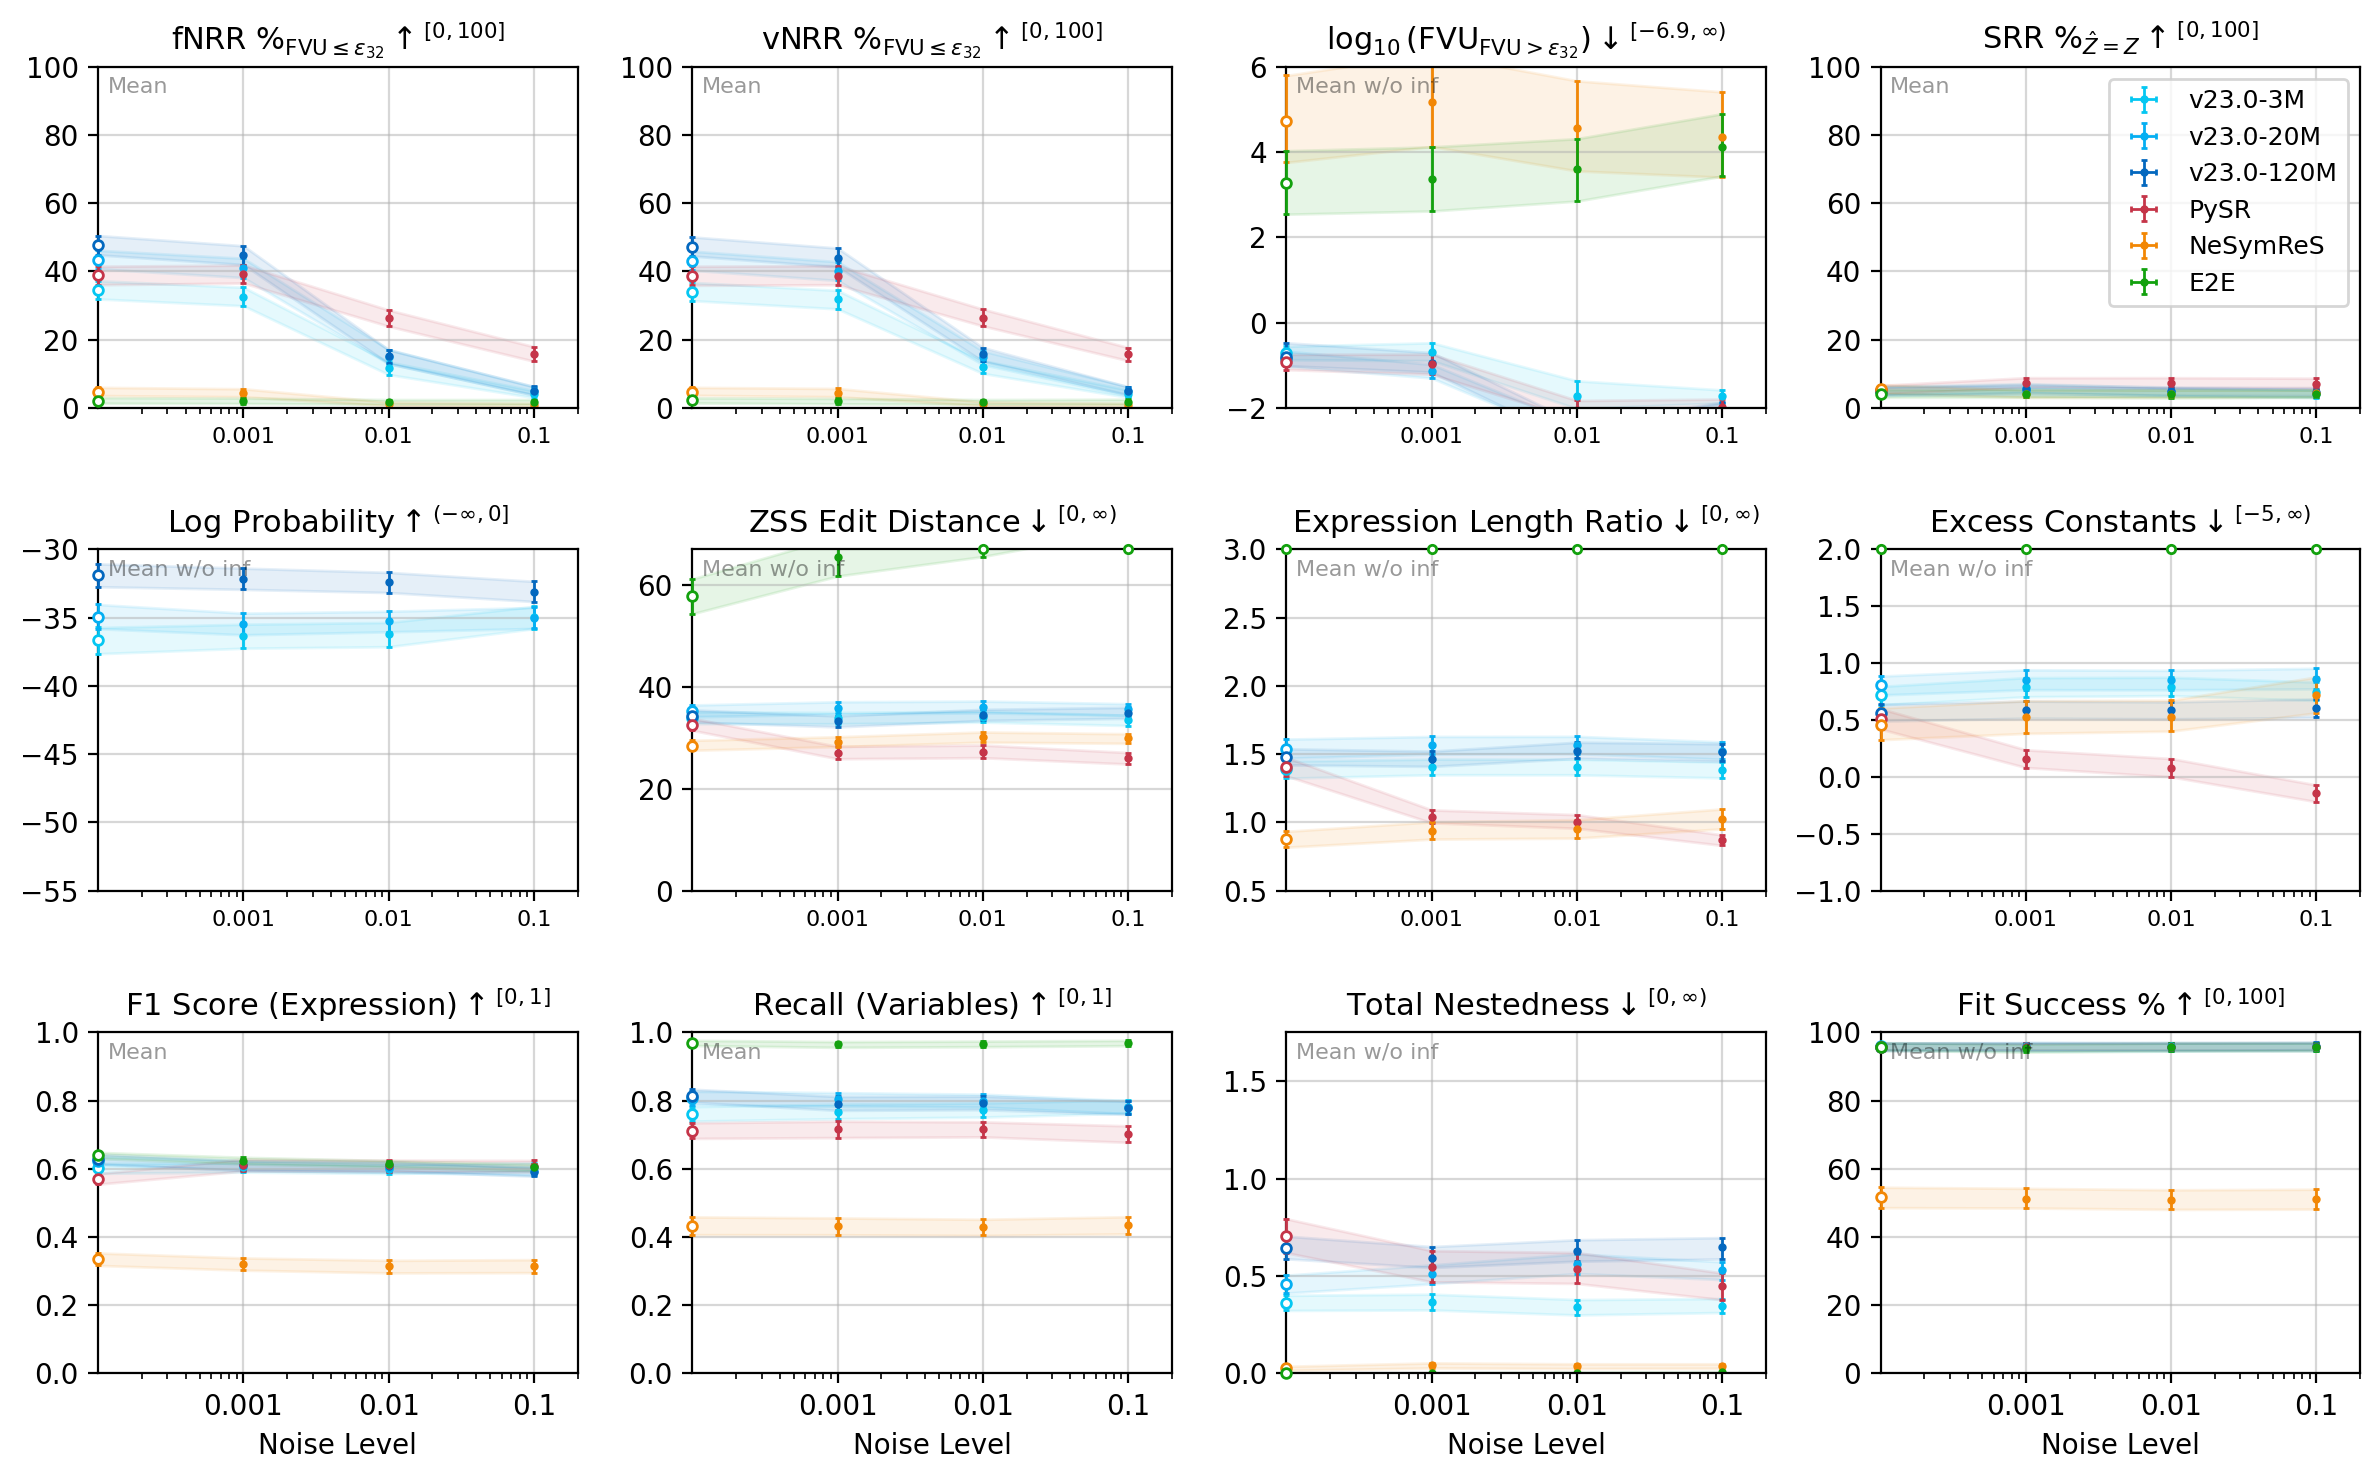

In [21]:
gt_constants = results['v23.0-3M']['results']['fastsrb'][0]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('noise_level', 'Noise Level', naninfmean), (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{FVU}}_{{\\mathrm{{FVU}} > \epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        naninfmean,
        1,
        (-2, 6)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'symbolic_recovery',
        f'SRR $\\%_{{\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'predicted_log_prob',
        f'$\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-55, -30)
    )),
    # (('noise_level', 'Noise Level', naninfmean), (
    #     'skeleton_length_ratio',
    #     f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
    #     naninfmean,
    #     1,
    #     (0.5, 2)
    # )),
    (('noise_level', 'Noise Level', naninfmean), (
        'zss_edit_distance',
        f'$\mathrm{{ZSS\\ Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 67)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'n_constants_delta',
        f'$\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=-max_gt_constants, upper=np.inf)}$',
        naninfmean,
        1,
        (-1, 2)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'f1_score',
        f'$\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1)
    )),
    # (('noise_level', 'Noise Level', naninfmean), (
    #     'precision_unique_variables',
    #     f'$\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
    #     np.nanmean,
    #     1,
    #     (0, 1)
    # )),
    (('noise_level', 'Noise Level', naninfmean), (
        'recall_unique_variables',
        f'$\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'predicted_total_nestedness',
        f'$\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 1.75)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'prediction_success',
        f'$\mathrm{{Fit\\ Success}}\\ \\% {arrow_notation(objective=1, lower=0, upper=100)}$',
        naninfmean,
        100,
        (0, 100)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    # ('v23.0-1B', 'choices', '#0339A6'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    ('e2e', 'candidates_per_bag', "#13a10e", 'E2E'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

test_set = 'fastsrb'
# test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)

short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

for ax_id, (ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation
            if y_metric == 'only_approx_log10_fvu_val':
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])

            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        # Convert to arrays and apply scaling factor
        x_median, x_lower, x_upper = np.array(x_median), np.array(x_lower), np.array(x_upper)
        y_median, y_lower, y_upper = np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        # Split data into Zero-Noise (x=0) and Non-Zero-Noise (x!=0)
        non_zero_mask = (x_median != 0)
        zero_mask = (x_median == 0)

        x_median_nonzero = x_median[non_zero_mask]
        x_lower_nonzero = x_lower[non_zero_mask]
        x_upper_nonzero = x_upper[non_zero_mask]
        y_median_nonzero = y_median[non_zero_mask]
        y_lower_nonzero = y_lower[non_zero_mask]
        y_upper_nonzero = y_upper[non_zero_mask]

        # ---------------------------------------------------------
        # 1. Plot Standard Curve (Non-Zero Noise)
        # ---------------------------------------------------------
        ax.errorbar(x_median_nonzero, y_median_nonzero, yerr=[y_median_nonzero - y_lower_nonzero, y_upper_nonzero - y_median_nonzero], xerr=[x_median_nonzero - x_lower_nonzero, x_upper_nonzero - x_median_nonzero],
                    fmt='.', label=model_label, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median_nonzero, y_lower_nonzero, y_upper_nonzero, color=color, alpha=0.1)

        # ---------------------------------------------------------
        # 2. Out-of-bounds Indicators for Standard Curve
        # ---------------------------------------------------------
        if ylim[1] is not None:
            upper_limit = ylim[1]
            oob_mask_nonzero = y_median_nonzero > upper_limit

            if np.any(oob_mask_nonzero):
                ax.plot(
                    x_median_nonzero[oob_mask_nonzero], 
                    np.full(oob_mask_nonzero.sum(), upper_limit), # Clamp y position to the upper limit
                    marker='o', 
                    linestyle='None', 
                    markerfacecolor='white', 
                    markeredgecolor=color, 
                    markeredgewidth=1.0,
                    markersize=3, 
                    clip_on=False, # Allow drawing on top of the axis spine
                    zorder=100     # Ensure it renders above the axis spine
                )

        # ---------------------------------------------------------
        # 3. Plot Zero-Noise Points (x=0 -> x=0.0001)
        # ---------------------------------------------------------
        x_median_zeros = x_median[zero_mask]
        y_median_zeros = y_median[zero_mask]
        y_lower_zeros = y_lower[zero_mask]
        y_upper_zeros = y_upper[zero_mask]

        if len(x_median_zeros) > 0:
            # Check if the zero-noise point is Out-Of-Bounds
            is_zero_oob = False
            if ylim[1] is not None and y_median_zeros[0] > ylim[1]:
                is_zero_oob = True

            if is_zero_oob:
                # Plot OOB style at x=0.0001 with clamped Y
                ax.plot(0.0001, ylim[1],
                        marker='o', linestyle='None', markerfacecolor='white',
                        markeredgecolor=color, markeredgewidth=1.0, markersize=3,
                        clip_on=False, zorder=100)
            else:
                # Plot Standard Zero style (White dot with error bars)
                ax.errorbar(0.0001, y_median_zeros, yerr=[y_median_zeros - y_lower_zeros, y_upper_zeros - y_median_zeros], fmt='o',
                            markerfacecolor='white', markeredgecolor=color, capsize=1, elinewidth=1, markersize=3.5, zorder=5, clip_on=False,
                            color=color)

            # Fill between the zero points and the first non-zero point to indicate uncertainty
            # We use the raw values for the fill, allowing it to be clipped by the axis naturally if needed
            if len(x_median_nonzero) > 0:
                ax.fill_between([0.0001, x_median_nonzero[0]], [y_lower_zeros[0], y_lower_nonzero[0]], [y_upper_zeros[0], y_upper_nonzero[0]], color=color, alpha=0.1)

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=10
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log', base=10)
    ax.set_xticks([0.001, 0.01, 0.1, 1])
    ax.set_xticklabels(['0.001', '0.01', '0.1', '1'], fontsize=x_ticks_fontsize)
    ax.set_xlim(0.0001, 0.2)

    ax.grid(alpha=0.5)

axes.flatten()[3].legend(fontsize=9)

for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')

    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'noise_scaling', create=True, filename=f'noise_scaling_{test_set}.svg'), dpi=200)

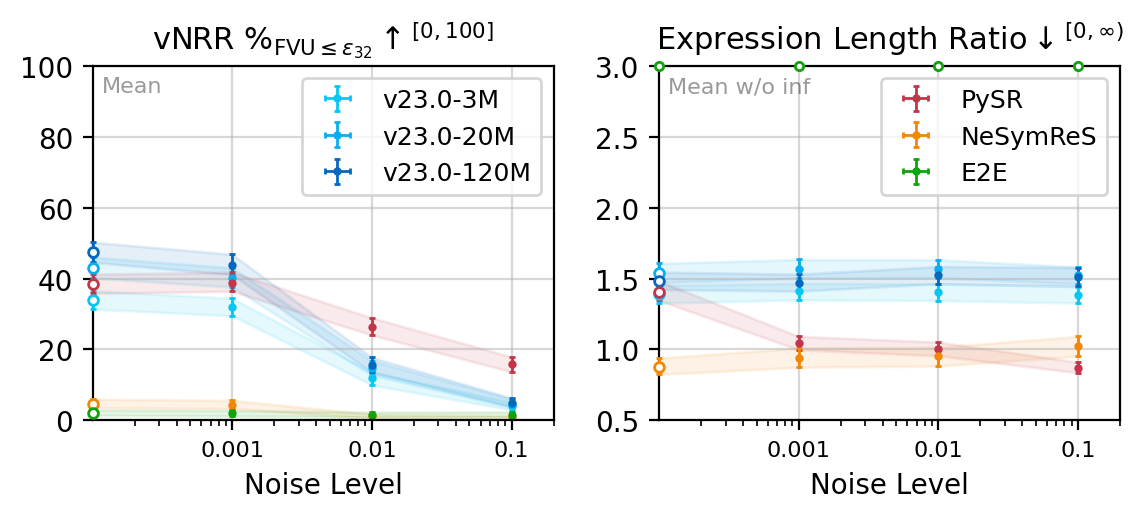

In [25]:
first_model = list(results.keys())[0]
gt_constants = results[first_model]['results']['fastsrb'][0]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('noise_level', 'Noise Level', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('noise_level', 'Noise Level', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    # ('v23.0-1B', 'choices', '#0339A6'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    ('e2e', 'candidates_per_bag', "#13a10e", 'E2E'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

if len(TEST_SETS) == 1:
    test_set = TEST_SETS[0]
else:
    test_set = 'fastsrb'
    # test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.9 * COLS, 2.7 * ROWS), dpi=200)

short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

models_per_legend_list = [
    ['v23.0-3M', 'v23.0-20M', 'v23.0-120M'],
    ['pysr', 'nesymres', 'e2e']
]

for ax_id, (models_per_legend, ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(models_per_legend_list, axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation
            if y_metric == 'only_approx_log10_fvu_val':
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])

            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper = np.array(x_median), np.array(x_lower), np.array(x_upper)
        y_median, y_lower, y_upper = np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        if model_name not in models_per_legend:
            model_label_shown = None
        else:
            model_label_shown = model_label

        non_zero_mask = (x_median != 0)
        zero_mask = (x_median == 0)

        x_median_nonzero = x_median[non_zero_mask]
        x_lower_nonzero = x_lower[non_zero_mask]
        x_upper_nonzero = x_upper[non_zero_mask]
        y_median_nonzero = y_median[non_zero_mask]
        y_lower_nonzero = y_lower[non_zero_mask]
        y_upper_nonzero = y_upper[non_zero_mask]

        # 1. Plot Standard Curve (Non-Zero Noise)
        ax.errorbar(x_median_nonzero, y_median_nonzero, yerr=[y_median_nonzero - y_lower_nonzero, y_upper_nonzero - y_median_nonzero], xerr=[x_median_nonzero - x_lower_nonzero, x_upper_nonzero - x_median_nonzero],
                    fmt='.', label=model_label_shown, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median_nonzero, y_lower_nonzero, y_upper_nonzero, color=color, alpha=0.1)

        # 2. Out-of-bounds Indicators for Standard Curve
        if ylim[1] is not None:
            upper_limit = ylim[1]
            oob_mask_nonzero = y_median_nonzero > upper_limit

            if np.any(oob_mask_nonzero):
                ax.plot(
                    x_median_nonzero[oob_mask_nonzero], 
                    np.full(oob_mask_nonzero.sum(), upper_limit), # Clamp y position to the upper limit
                    marker='o', 
                    linestyle='None', 
                    markerfacecolor='white', 
                    markeredgecolor=color, 
                    markeredgewidth=1.0,
                    markersize=3, 
                    clip_on=False, # Allow drawing on top of the axis spine
                    zorder=100     # Ensure it renders above the axis spine
                )

        # 3. Plot Zero-Noise Points (x=0 -> x=0.0001)
        x_median_zeros = x_median[zero_mask]
        y_median_zeros = y_median[zero_mask]
        y_lower_zeros = y_lower[zero_mask]
        y_upper_zeros = y_upper[zero_mask]

        if len(x_median_zeros) > 0:
            # Check if the zero-noise point is Out-Of-Bounds
            is_zero_oob = False
            if ylim[1] is not None and y_median_zeros[0] > ylim[1]:
                is_zero_oob = True

            if is_zero_oob:
                # Plot OOB style at x=0.0001 with clamped Y
                ax.plot(0.0001, ylim[1],
                        marker='o', linestyle='None', markerfacecolor='white',
                        markeredgecolor=color, markeredgewidth=1.0, markersize=3,
                        clip_on=False, zorder=100)
            else:
                # Plot Standard Zero style (White dot with error bars)
                ax.errorbar(0.0001, y_median_zeros, yerr=[y_median_zeros - y_lower_zeros, y_upper_zeros - y_median_zeros], fmt='o',
                            markerfacecolor='white', markeredgecolor=color, capsize=1, elinewidth=1, markersize=3.5, zorder=5, clip_on=False,
                            color=color)

            # Fill between the zero points and the first non-zero point to indicate uncertainty
            if len(x_median_nonzero) > 0:
                ax.fill_between([0.0001, x_median_nonzero[0]], [y_lower_zeros[0], y_lower_nonzero[0]], [y_upper_zeros[0], y_upper_nonzero[0]], color=color, alpha=0.1)

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=8
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log', base=10)
    ax.set_xticks([0.001, 0.01, 0.1, 1])
    ax.set_xticklabels(['0.001', '0.01', '0.1', '1'], fontsize=x_ticks_fontsize)
    ax.set_xlim(0.0001, 0.2)

    ax.grid(alpha=0.5)

axes.flatten()[0].legend(fontsize=9, loc='upper right')
axes.flatten()[1].legend(fontsize=9, loc='upper right')

for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')

    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=1.5, h_pad=2)

plt.savefig(get_path('results', 'noise_scaling', create=True, filename=f'small_noise_scaling_{test_set}.svg'), dpi=200)